In [5]:
!pip install gdown

In [6]:
!gdown '1lKIyy2brZJDljHLuAbM3SuBEzTiyiPrq' --output processed_dataset.csv
!gdown '1I4jfPhccUnENqqBoF88mQLotOjrlO4Xt' --output raw_predictions.csv

Downloading...
From: https://drive.google.com/uc?id=1lKIyy2brZJDljHLuAbM3SuBEzTiyiPrq
To: /content/processed_dataset.csv
100% 125k/125k [00:00<00:00, 4.94MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I4jfPhccUnENqqBoF88mQLotOjrlO4Xt
To: /content/raw_predictions.csv
100% 125k/125k [00:00<00:00, 8.74MB/s]


## 1. 🔧 Cài đặt và Import

In [7]:
import subprocess
import sys

# Cài đặt scikit-learn nếu chưa có
try:
    import sklearn
except ImportError:
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])

# Cài đặt dog_emotion_ml package (nếu có)
try:
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'git+https://github.com/hoangh-e/dog-emotion-recognition-hybrid.git'],
                   capture_output=True, text=True)
    print("✅ Đã cài đặt dog_emotion_ml package")
except:
    print("⚠️  Không thể cài đặt dog_emotion_ml package, sẽ sử dụng implementation tự viết")

# %%
# Import các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Đã import thành công các thư viện!")


✅ Đã cài đặt dog_emotion_ml package
✅ Đã import thành công các thư viện!


## 2. 📂 Tải và Kiểm tra Dữ liệu

In [8]:
CSV_FILE_PATH = "/content/processed_dataset.csv"  # 🔄 THAY ĐỔI ĐƯỜNG DẪN NÀY

# Nếu không có file, tạo dữ liệu mẫu để demo
def create_sample_data(n_samples=1000):
    """Tạo dữ liệu mẫu để demo"""
    np.random.seed(42)

    # Tạo ResNet emotion features (xác suất)
    emotion_data = np.random.dirichlet([2, 1, 3, 1], n_samples)  # Bias toward happy

    # Tạo YOLO tail features (có thể là xác suất hoặc binary)
    tail_data = np.random.dirichlet([1, 2, 1], n_samples)  # Bias toward up

    # Tạo labels
    labels = np.random.choice(['sad', 'angry', 'happy', 'relaxed'],
                             n_samples, p=[0.2, 0.15, 0.45, 0.2])

    # Tạo DataFrame
    data = pd.DataFrame({
        'filename': [f'dog_image_{i:04d}.jpg' for i in range(n_samples)],
        'sad': emotion_data[:, 0],
        'angry': emotion_data[:, 1],
        'happy': emotion_data[:, 2],
        'relaxed': emotion_data[:, 3],
        'down': tail_data[:, 0],
        'up': tail_data[:, 1],
        'mid': tail_data[:, 2],
        'label': labels
    })

    return data

# Thử tải dữ liệu thực, nếu không có thì tạo dữ liệu mẫu
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"✅ Đã tải dữ liệu từ: {CSV_FILE_PATH}")
    print(f"📊 Kích thước dữ liệu: {df.shape}")
except:
    print("⚠️  Không tìm thấy file dữ liệu, tạo dữ liệu mẫu...")
    df = create_sample_data(1000)
    print(f"📊 Đã tạo dữ liệu mẫu: {df.shape}")

# Hiển thị thông tin dữ liệu
print("\n📋 Thông tin dữ liệu:")
print(df.info())

print("\n📊 Mẫu dữ liệu (5 dòng đầu):")
print(df.head())

✅ Đã tải dữ liệu từ: /content/processed_dataset.csv
📊 Kích thước dữ liệu: (489, 11)

📋 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         489 non-null    object 
 1   sad              489 non-null    float64
 2   angry            489 non-null    float64
 3   happy            489 non-null    float64
 4   relaxed          489 non-null    float64
 5   down             489 non-null    float64
 6   up               489 non-null    float64
 7   mid              489 non-null    float64
 8   label            489 non-null    object 
 9   head_confidence  489 non-null    float64
 10  head_bbox        489 non-null    object 
dtypes: float64(8), object(3)
memory usage: 42.2+ KB
None

📊 Mẫu dữ liệu (5 dòng đầu):
                                            filename       sad     angry  \
0  166510946_jpg.rf.275da3ef

In [9]:
# Kiểm tra các cột cần thiết
REQUIRED_COLUMNS = {
    'emotion_cols': ['sad', 'angry', 'happy', 'relaxed'],
    'tail_cols': ['down', 'up', 'mid'],
    'other_cols': ['filename', 'label']
}

print("🔍 Kiểm tra cấu trúc dữ liệu:")
missing_cols = []

for col_type, cols in REQUIRED_COLUMNS.items():
    for col in cols:
        if col in df.columns:
            print(f"   ✅ {col}")
        else:
            print(f"   ❌ {col} (thiếu)")
            missing_cols.append(col)

if missing_cols:
    print(f"\n⚠️  Cảnh báo: Thiếu các cột: {missing_cols}")
    print("Vui lòng kiểm tra lại tên cột trong file CSV")
else:
    print(f"\n✅ Tất cả cột cần thiết đều có sẵn!")


🔍 Kiểm tra cấu trúc dữ liệu:
   ✅ sad
   ✅ angry
   ✅ happy
   ✅ relaxed
   ✅ down
   ✅ up
   ✅ mid
   ✅ filename
   ✅ label

✅ Tất cả cột cần thiết đều có sẵn!


## 3. 📈 Phân tích Dữ liệu Trước Chuẩn hóa

In [10]:
# Phân tích thống kê mô tả
emotion_cols = ['sad', 'angry', 'happy', 'relaxed']
tail_cols = ['down', 'up', 'mid']

print("📊 THỐNG KÊ MÔ TẢ - TRƯỚC CHUẨN HÓA")
print("=" * 50)

print("\n🎭 ResNet Emotion Features:")
emotion_stats = df[emotion_cols].describe()
print(emotion_stats)

print("\n🐕 YOLO Tail Features:")
tail_stats = df[tail_cols].describe()
print(tail_stats)

# Kiểm tra tổng xác suất
print("\n🔍 Kiểm tra tổng xác suất:")
emotion_sums = df[emotion_cols].sum(axis=1)
tail_sums = df[tail_cols].sum(axis=1)

print(f"Emotion features - Tổng trung bình: {emotion_sums.mean():.4f} (±{emotion_sums.std():.4f})")
print(f"Tail features - Tổng trung bình: {tail_sums.mean():.4f} (±{tail_sums.std():.4f})")


📊 THỐNG KÊ MÔ TẢ - TRƯỚC CHUẨN HÓA

🎭 ResNet Emotion Features:
              sad       angry       happy     relaxed
count  489.000000  489.000000  489.000000  489.000000
mean     0.160380    0.416011    0.297966    0.125643
std      0.242218    0.392842    0.296916    0.175030
min      0.000494    0.001280    0.000059    0.000016
25%      0.023125    0.055265    0.007439    0.002372
50%      0.057232    0.225856    0.233333    0.044719
75%      0.153112    0.890280    0.579707    0.181434
max      0.997323    0.998796    0.918903    0.930883

🐕 YOLO Tail Features:
             down          up         mid
count  489.000000  489.000000  489.000000
mean     0.209497    0.496504    0.293999
std      0.405487    0.494894    0.450460
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.497104    0.000000
75%      0.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

🔍 Kiểm tra tổng xác suất:
Emotion features - Tổng

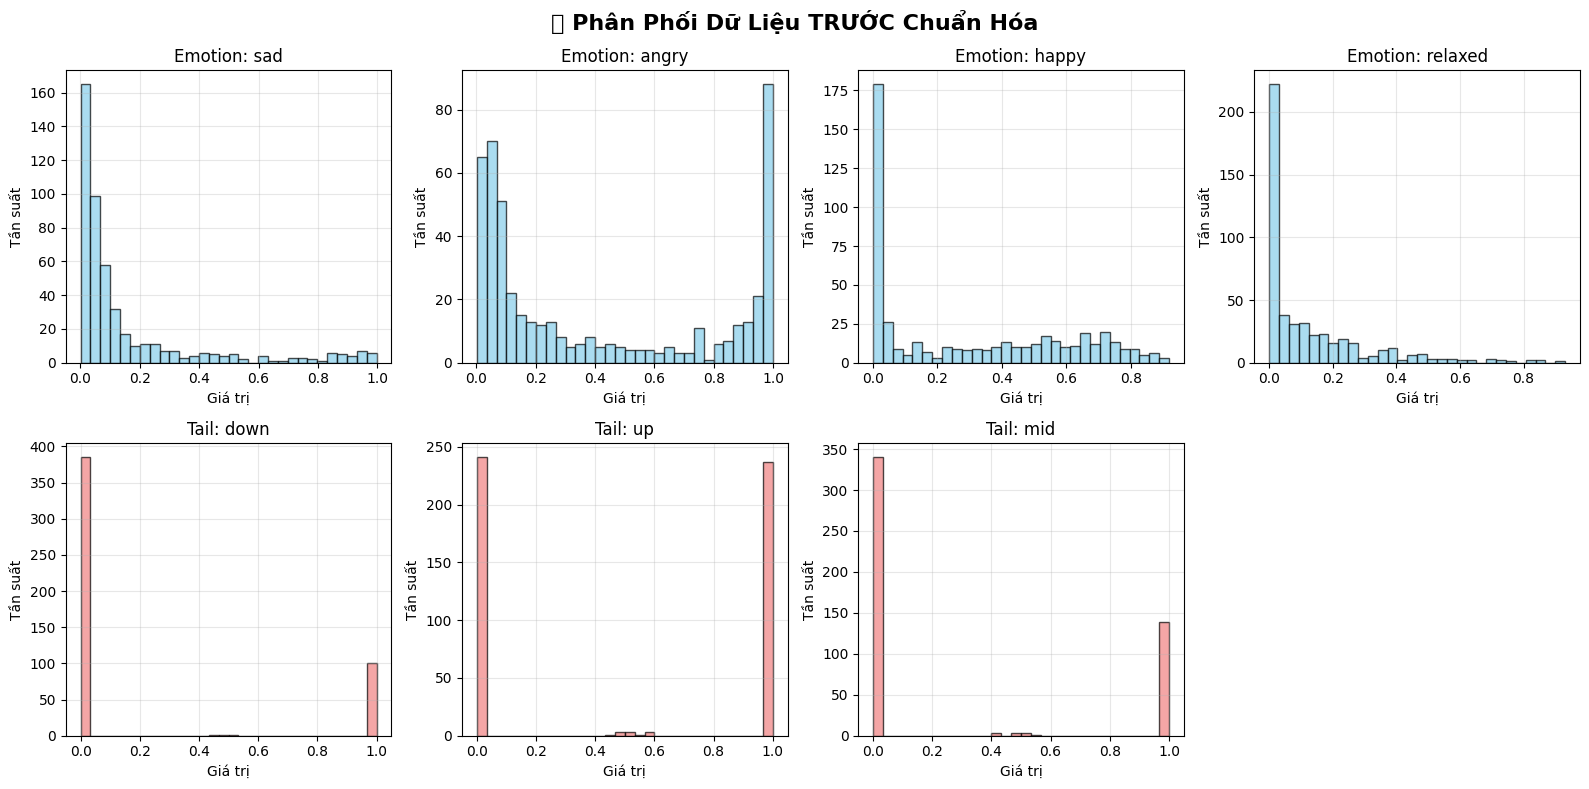

In [11]:
# Visualize phân phối dữ liệu trước chuẩn hóa
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('📊 Phân Phối Dữ Liệu TRƯỚC Chuẩn Hóa', fontsize=16, fontweight='bold')

# Plot emotion features
for i, col in enumerate(emotion_cols):
    axes[0, i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f'Emotion: {col}')
    axes[0, i].set_xlabel('Giá trị')
    axes[0, i].set_ylabel('Tần suất')
    axes[0, i].grid(True, alpha=0.3)

# Plot tail features
for i, col in enumerate(tail_cols):
    axes[1, i].hist(df[col], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, i].set_title(f'Tail: {col}')
    axes[1, i].set_xlabel('Giá trị')
    axes[1, i].set_ylabel('Tần suất')
    axes[1, i].grid(True, alpha=0.3)

# Empty subplot
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

🔗 Ma trận tương quan:


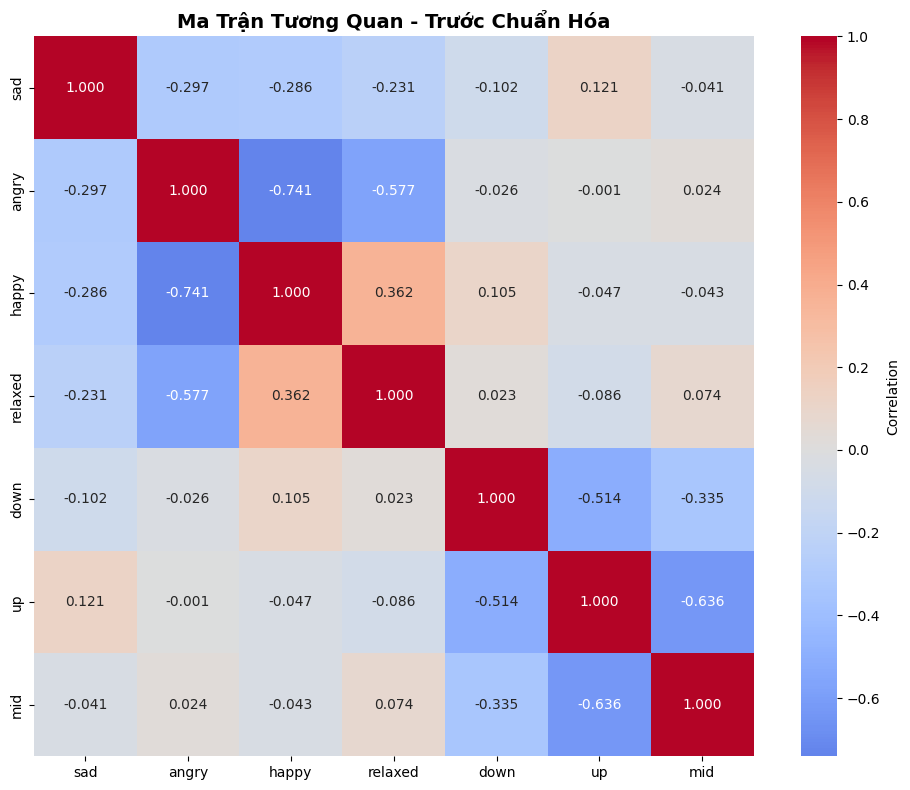

In [12]:
# Phân tích correlation
print("🔗 Ma trận tương quan:")
correlation_matrix = df[emotion_cols + tail_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Ma Trận Tương Quan - Trước Chuẩn Hóa', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. 🔄 Thực hiện Chuẩn hóa Dữ liệu

In [13]:
# Class để thực hiện chuẩn hóa dữ liệu
class DataNormalizer:
    """
    Class chuẩn hóa dữ liệu theo phương pháp:
    - ResNet emotion features: Z-score normalization (StandardScaler)
    - YOLO tail features: Pass-through (không chuẩn hóa)
    """

    def __init__(self):
        self.emotion_scaler = StandardScaler()
        self.tail_scaler = None  # Pass-through
        self.is_fitted = False

    def fit(self, X_emotion, X_tail=None):
        """
        Fit scaler trên dữ liệu training

        Args:
            X_emotion: array-like, emotion features [sad, angry, happy, relaxed]
            X_tail: array-like, tail features [down, up, mid] (optional)
        """
        print("🔧 Fitting normalizers...")

        # Fit emotion scaler (Z-score)
        self.emotion_scaler.fit(X_emotion)
        print(f"   ✅ Emotion scaler fitted - Mean: {self.emotion_scaler.mean_}")
        print(f"   ✅ Emotion scaler fitted - Std: {self.emotion_scaler.scale_}")

        # Tail features: pass-through (không cần fit)
        if X_tail is not None:
            print(f"   ✅ Tail features: pass-through (không chuẩn hóa)")

        self.is_fitted = True
        return self

    def transform(self, X_emotion, X_tail=None):
        """
        Transform dữ liệu

        Args:
            X_emotion: array-like, emotion features
            X_tail: array-like, tail features (optional)

        Returns:
            tuple: (emotion_normalized, tail_passthrough)
        """
        if not self.is_fitted:
            raise ValueError("Normalizer chưa được fit. Gọi fit() trước.")

        # Transform emotion features (Z-score)
        X_emotion_norm = self.emotion_scaler.transform(X_emotion)

        # Tail features: pass-through
        X_tail_norm = X_tail.copy() if X_tail is not None else None

        return X_emotion_norm, X_tail_norm

    def fit_transform(self, X_emotion, X_tail=None):
        """Fit và transform trong một bước"""
        return self.fit(X_emotion, X_tail).transform(X_emotion, X_tail)

    def inverse_transform_emotion(self, X_emotion_normalized):
        """Inverse transform cho emotion features"""
        if not self.is_fitted:
            raise ValueError("Normalizer chưa được fit.")
        return self.emotion_scaler.inverse_transform(X_emotion_normalized)


In [14]:
# Chuẩn bị dữ liệu để chuẩn hóa
print("📋 Chuẩn bị dữ liệu để chuẩn hóa...")

# Tách features
X_emotion = df[emotion_cols].values
X_tail = df[tail_cols].values

print(f"   Emotion features shape: {X_emotion.shape}")
print(f"   Tail features shape: {X_tail.shape}")

# Kiểm tra dữ liệu trước chuẩn hóa
print(f"\n📊 Thống kê TRƯỚC chuẩn hóa:")
print(f"   Emotion - Mean: {X_emotion.mean(axis=0)}")
print(f"   Emotion - Std: {X_emotion.std(axis=0)}")
print(f"   Tail - Mean: {X_tail.mean(axis=0)}")
print(f"   Tail - Std: {X_tail.std(axis=0)}")

📋 Chuẩn bị dữ liệu để chuẩn hóa...
   Emotion features shape: (489, 4)
   Tail features shape: (489, 3)

📊 Thống kê TRƯỚC chuẩn hóa:
   Emotion - Mean: [0.1603799  0.41601063 0.29796615 0.12564331]
   Emotion - Std: [0.24197015 0.39244042 0.29661215 0.1748507 ]
   Tail - Mean: [0.20949698 0.49650404 0.29399897]
   Tail - Std: [0.4050722  0.49438786 0.44999962]


In [15]:
# Thực hiện chuẩn hóa
print("🔄 Thực hiện chuẩn hóa dữ liệu...")

# Khởi tạo normalizer
normalizer = DataNormalizer()

# Fit và transform
X_emotion_norm, X_tail_norm = normalizer.fit_transform(X_emotion, X_tail)

print(f"\n✅ Hoàn thành chuẩn hóa!")
print(f"   Emotion normalized shape: {X_emotion_norm.shape}")
print(f"   Tail passthrough shape: {X_tail_norm.shape}")

# Kiểm tra kết quả sau chuẩn hóa
print(f"\n📊 Thống kê SAU chuẩn hóa:")
print(f"   Emotion - Mean: {X_emotion_norm.mean(axis=0)}")
print(f"   Emotion - Std: {X_emotion_norm.std(axis=0)}")
print(f"   Tail - Mean: {X_tail_norm.mean(axis=0)} (không đổi)")
print(f"   Tail - Std: {X_tail_norm.std(axis=0)} (không đổi)")


🔄 Thực hiện chuẩn hóa dữ liệu...
🔧 Fitting normalizers...
   ✅ Emotion scaler fitted - Mean: [0.1603799  0.41601063 0.29796615 0.12564331]
   ✅ Emotion scaler fitted - Std: [0.24197015 0.39244042 0.29661215 0.1748507 ]
   ✅ Tail features: pass-through (không chuẩn hóa)

✅ Hoàn thành chuẩn hóa!
   Emotion normalized shape: (489, 4)
   Tail passthrough shape: (489, 3)

📊 Thống kê SAU chuẩn hóa:
   Emotion - Mean: [1.08978947e-16 0.00000000e+00 0.00000000e+00 7.26526315e-18]
   Emotion - Std: [1. 1. 1. 1.]
   Tail - Mean: [0.20949698 0.49650404 0.29399897] (không đổi)
   Tail - Std: [0.4050722  0.49438786 0.44999962] (không đổi)


## 5. 📊 Phân tích Kết quả Chuẩn hóa


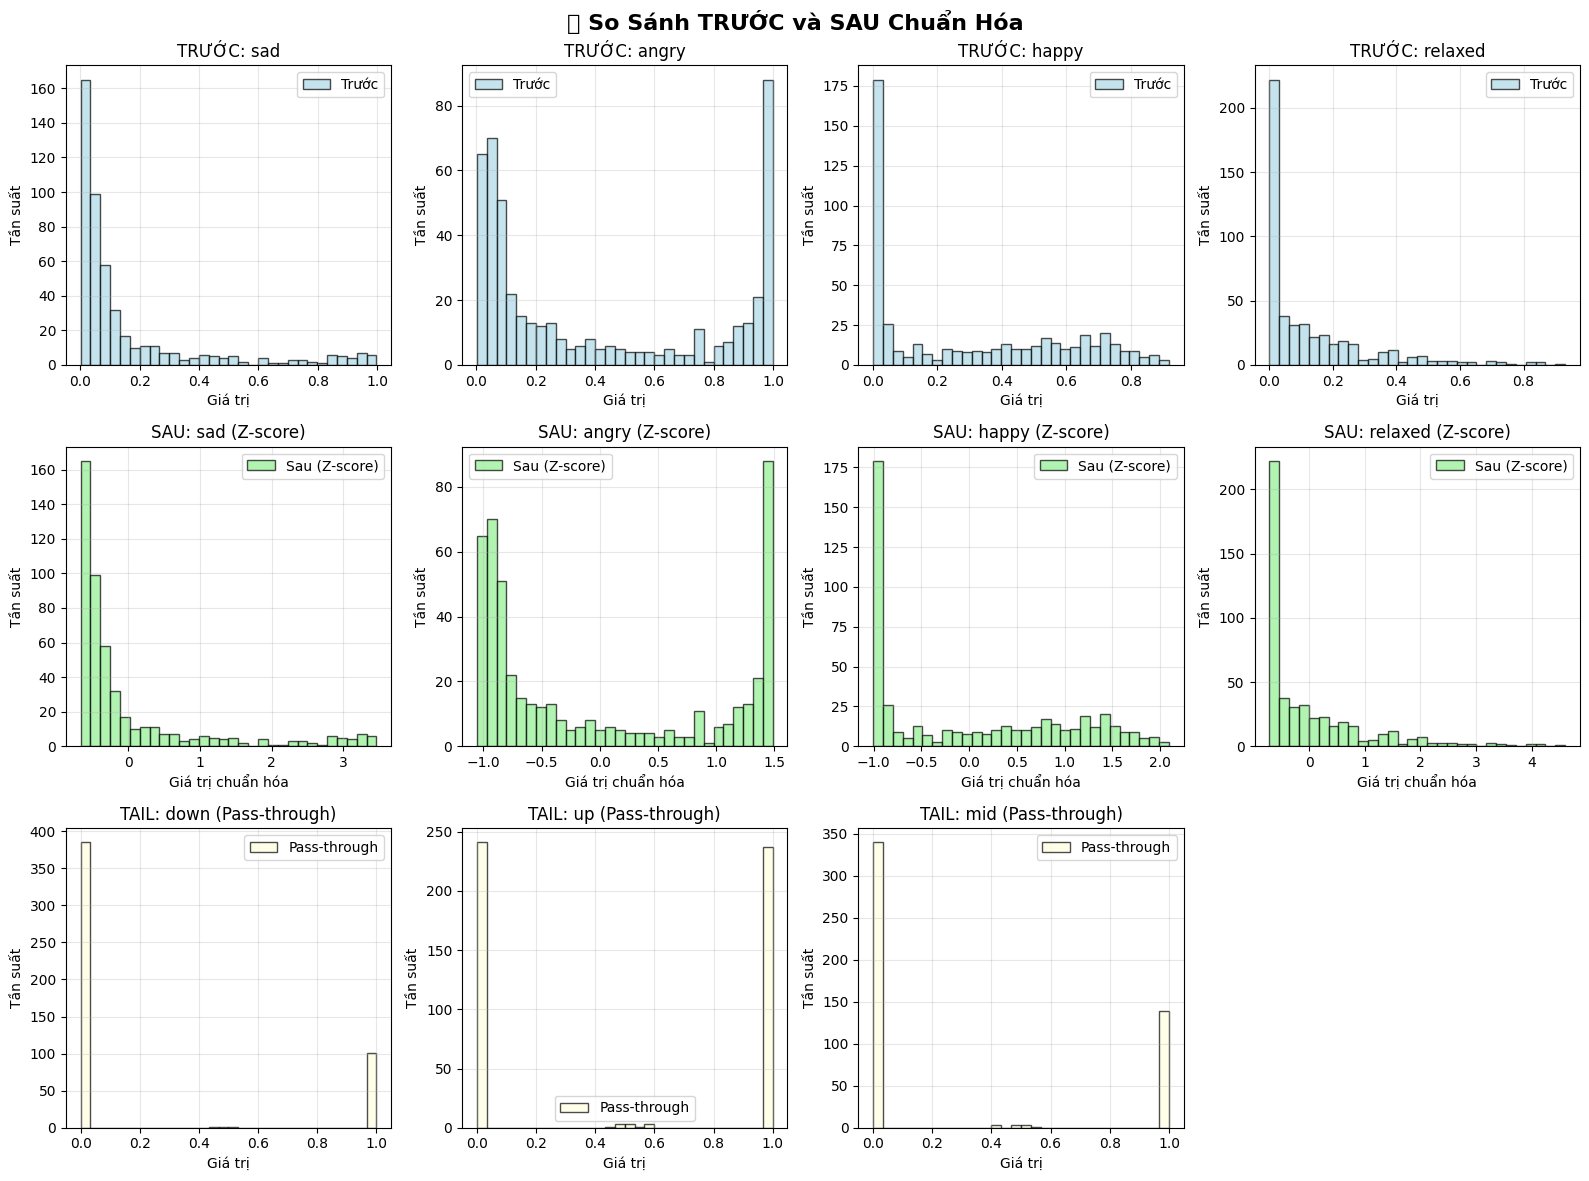

In [16]:
# So sánh trước và sau chuẩn hóa
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('📊 So Sánh TRƯỚC và SAU Chuẩn Hóa', fontsize=16, fontweight='bold')

# Emotion features - Trước chuẩn hóa
for i, col in enumerate(emotion_cols):
    axes[0, i].hist(X_emotion[:, i], bins=30, alpha=0.7, color='lightblue',
                    edgecolor='black', label='Trước')
    axes[0, i].set_title(f'TRƯỚC: {col}')
    axes[0, i].set_xlabel('Giá trị')
    axes[0, i].set_ylabel('Tần suất')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].legend()

# Emotion features - Sau chuẩn hóa (Z-score)
for i, col in enumerate(emotion_cols):
    axes[1, i].hist(X_emotion_norm[:, i], bins=30, alpha=0.7, color='lightgreen',
                    edgecolor='black', label='Sau (Z-score)')
    axes[1, i].set_title(f'SAU: {col} (Z-score)')
    axes[1, i].set_xlabel('Giá trị chuẩn hóa')
    axes[1, i].set_ylabel('Tần suất')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()

# Tail features - Pass-through (không đổi)
for i, col in enumerate(tail_cols):
    axes[2, i].hist(X_tail_norm[:, i], bins=30, alpha=0.7, color='lightyellow',
                    edgecolor='black', label='Pass-through')
    axes[2, i].set_title(f'TAIL: {col} (Pass-through)')
    axes[2, i].set_xlabel('Giá trị')
    axes[2, i].set_ylabel('Tần suất')
    axes[2, i].grid(True, alpha=0.3)
    axes[2, i].legend()

# Empty subplot
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()


In [17]:
# Kiểm tra tính chất Z-score
print("🔍 KIỂM TRA TÍNH CHẤT Z-SCORE:")
print("=" * 40)

for i, col in enumerate(emotion_cols):
    mean_val = X_emotion_norm[:, i].mean()
    std_val = X_emotion_norm[:, i].std()
    print(f"{col:10s}: Mean = {mean_val:8.6f}, Std = {std_val:8.6f}")

print(f"\n✅ Kết quả mong đợi: Mean ≈ 0.000000, Std ≈ 1.000000")

# Kiểm tra tail features không đổi
print(f"\n🔍 KIỂM TRA TAIL FEATURES (Pass-through):")
print("=" * 45)

tail_unchanged = np.allclose(X_tail, X_tail_norm)
print(f"Tail features không thay đổi: {tail_unchanged}")

if tail_unchanged:
    print("✅ Tail features được pass-through thành công!")
else:
    print("❌ Có lỗi trong quá trình pass-through tail features")


🔍 KIỂM TRA TÍNH CHẤT Z-SCORE:
sad       : Mean = 0.000000, Std = 1.000000
angry     : Mean = 0.000000, Std = 1.000000
happy     : Mean = 0.000000, Std = 1.000000
relaxed   : Mean = 0.000000, Std = 1.000000

✅ Kết quả mong đợi: Mean ≈ 0.000000, Std ≈ 1.000000

🔍 KIỂM TRA TAIL FEATURES (Pass-through):
Tail features không thay đổi: True
✅ Tail features được pass-through thành công!


## 6. 💾 Tạo Dataset Đã Chuẩn hóa

In [18]:
# Tạo DataFrame mới với dữ liệu đã chuẩn hóa
print("💾 Tạo dataset đã chuẩn hóa...")

# Tạo DataFrame mới
df_normalized = df.copy()

# Cập nhật emotion features với giá trị đã chuẩn hóa
for i, col in enumerate(emotion_cols):
    df_normalized[col] = X_emotion_norm[:, i]

# Tail features giữ nguyên (pass-through)
for i, col in enumerate(tail_cols):
    df_normalized[col] = X_tail_norm[:, i]

# Thêm suffix để phân biệt
df_normalized.columns = [col + '_normalized' if col in emotion_cols + tail_cols else col
                        for col in df_normalized.columns]

print(f"✅ Đã tạo dataset chuẩn hóa: {df_normalized.shape}")

# Hiển thị mẫu dữ liệu đã chuẩn hóa
print(f"\n📊 Mẫu dữ liệu đã chuẩn hóa:")
print(df_normalized.head())


💾 Tạo dataset đã chuẩn hóa...
✅ Đã tạo dataset chuẩn hóa: (489, 11)

📊 Mẫu dữ liệu đã chuẩn hóa:
                                            filename  sad_normalized  \
0  166510946_jpg.rf.275da3ef2e388c1a1ed4bc4e91ed5...        3.313975   
1  1MLMzBLgXPxaPHQRgs2Ws2UQJJZsaG300_jpg.rf.b0755...        0.875003   
2  3qnxVgf3GQjABK8iGeZu8eE1CGU5eH645_jpg.rf.9c147...        3.248865   
3  A0058_jpg.rf.5114adf2e7c430b5f2b0d5cb1868098f.jpg        3.253864   
4  A0076_jpg.rf.ff95d92ff1d6cb1873e4ad260ecec9f0.jpg        1.822993   

   angry_normalized  happy_normalized  relaxed_normalized  down_normalized  \
0         -0.967326         -1.001731           -0.715695              0.0   
1         -0.180625         -0.180273           -0.499679              0.0   
2         -0.925601         -1.003302           -0.716574              0.0   
3         -0.928297         -1.003529           -0.717057              0.0   
4         -0.061689         -0.986211           -0.711340              0.0   

 

In [19]:
# Tạo dataset cuối cùng với tên cột gốc
print("📋 Tạo dataset cuối cùng...")

# Dataset cuối cùng với tên cột gốc
df_final = df.copy()

# Cập nhật emotion features
for i, col in enumerate(emotion_cols):
    df_final[col] = X_emotion_norm[:, i]

# Tail features giữ nguyên
for i, col in enumerate(tail_cols):
    df_final[col] = X_tail_norm[:, i]

print(f"✅ Dataset cuối cùng: {df_final.shape}")

# So sánh trước và sau
print(f"\n📊 So sánh mẫu dữ liệu:")
print("TRƯỚC chuẩn hóa:")
print(df[emotion_cols + tail_cols].head(3))

print("\nSAU chuẩn hóa:")
print(df_final[emotion_cols + tail_cols].head(3))


📋 Tạo dataset cuối cùng...
✅ Dataset cuối cùng: (489, 11)

📊 So sánh mẫu dữ liệu:
TRƯỚC chuẩn hóa:
        sad     angry     happy   relaxed  down   up  mid
0  0.962263  0.036393  0.000841  0.000503   0.0  0.0  1.0
1  0.372105  0.345126  0.244495  0.038274   0.0  1.0  0.0
2  0.946508  0.052767  0.000375  0.000350   0.0  1.0  0.0

SAU chuẩn hóa:
        sad     angry     happy   relaxed  down   up  mid
0  3.313975 -0.967326 -1.001731 -0.715695   0.0  0.0  1.0
1  0.875003 -0.180625 -0.180273 -0.499679   0.0  1.0  0.0
2  3.248865 -0.925601 -1.003302 -0.716574   0.0  1.0  0.0


## 7. 💾 Lưu Kết quả

In [20]:
# Lưu dataset đã chuẩn hóa
OUTPUT_FILE = "/content/normalized_data.csv"  # 🔄 THAY ĐỔI ĐƯỜNG DẪN NÀY

print(f"💾 Lưu dataset đã chuẩn hóa...")

# Lưu file CSV
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Đã lưu: {OUTPUT_FILE}")

# Lưu thông tin chuẩn hóa
SCALER_INFO_FILE = "/content/normalization_info.txt"

with open(SCALER_INFO_FILE, 'w', encoding='utf-8') as f:
    f.write("THÔNG TIN CHUẨN HÓA DỮ LIỆU\n")
    f.write("=" * 50 + "\n\n")

    f.write("PHƯƠNG PHÁP CHUẨN HÓA:\n")
    f.write(f"- ResNet emotion features: Z-score normalization (StandardScaler)\n")
    f.write(f"- YOLO tail features: Pass-through (không chuẩn hóa)\n\n")

    f.write("EMOTION FEATURES (Z-score):\n")
    f.write(f"- Columns: {emotion_cols}\n")
    f.write(f"- Original mean: {X_emotion.mean(axis=0)}\n")
    f.write(f"- Original std: {X_emotion.std(axis=0)}\n")
    f.write(f"- Normalized mean: {X_emotion_norm.mean(axis=0)}\n")
    f.write(f"- Normalized std: {X_emotion_norm.std(axis=0)}\n\n")

    f.write("TAIL FEATURES (Pass-through):\n")
    f.write(f"- Columns: {tail_cols}\n")
    f.write(f"- Mean: {X_tail.mean(axis=0)} (không đổi)\n")
    f.write(f"- Std: {X_tail.std(axis=0)} (không đổi)\n\n")

    f.write(f"DATASET INFO:\n")
    f.write(f"- Tổng số mẫu: {len(df_final)}\n")
    f.write(f"- Tổng số features: {len(emotion_cols + tail_cols)}\n")
    f.write(f"- File đầu ra: {OUTPUT_FILE}\n")

print(f"✅ Đã lưu thông tin chuẩn hóa: {SCALER_INFO_FILE}")


💾 Lưu dataset đã chuẩn hóa...
✅ Đã lưu: /content/normalized_data.csv
✅ Đã lưu thông tin chuẩn hóa: /content/normalization_info.txt


In [21]:
# Lưu scaler để sử dụng sau này
import joblib

SCALER_FILE = "/content/emotion_scaler.pkl"

# Lưu scaler
joblib.dump(normalizer.emotion_scaler, SCALER_FILE)
print(f"✅ Đã lưu emotion scaler: {SCALER_FILE}")

# Test load scaler
loaded_scaler = joblib.load(SCALER_FILE)
print(f"✅ Test load scaler thành công!")


✅ Đã lưu emotion scaler: /content/emotion_scaler.pkl
✅ Test load scaler thành công!


## 8. ✅ Tóm tắt và Hướng dẫn Sử dụng

In [22]:
# Tóm tắt kết quả
print("🎉 HOÀN THÀNH CHUẨN HÓA DỮ LIỆU!")
print("=" * 50)

print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
print(f"   📁 File đầu vào: {CSV_FILE_PATH}")
print(f"   📁 File đầu ra: {OUTPUT_FILE}")
print(f"   📈 Số mẫu: {len(df_final):,}")
print(f"   🎯 Emotion features: {len(emotion_cols)} (Z-score normalized)")
print(f"   🐕 Tail features: {len(tail_cols)} (pass-through)")

print(f"\n🔧 PHƯƠNG PHÁP CHUẨN HÓA:")
print(f"   ✅ ResNet emotion features: StandardScaler (Z-score)")
print(f"      - Trung bình: 0.000000")
print(f"      - Độ lệch chuẩn: 1.000000")
print(f"   ✅ YOLO tail features: Pass-through")
print(f"      - Giữ nguyên giá trị gốc")

print(f"\n📁 FILES ĐÃ TẠO:")
print(f"   📄 {OUTPUT_FILE} - Dataset đã chuẩn hóa")
print(f"   📄 {SCALER_INFO_FILE} - Thông tin chuẩn hóa")
print(f"   📄 {SCALER_FILE} - Emotion scaler (để sử dụng sau)")

print(f"\n🚀 HƯỚNG DẪN SỬ DỤNG:")
print(f"   1. Sử dụng {OUTPUT_FILE} để huấn luyện ML models")
print(f"   2. Load scaler từ {SCALER_FILE} để chuẩn hóa dữ liệu mới:")
print(f"""
   import joblib
   scaler = joblib.load('{SCALER_FILE}')
   new_emotion_normalized = scaler.transform(new_emotion_data)
   # Tail features không cần chuẩn hóa
   """)

print(f"\n✅ Dataset đã sẵn sàng cho việc huấn luyện Machine Learning!")

🎉 HOÀN THÀNH CHUẨN HÓA DỮ LIỆU!

📊 THỐNG KÊ TỔNG QUAN:
   📁 File đầu vào: /content/processed_dataset.csv
   📁 File đầu ra: /content/normalized_data.csv
   📈 Số mẫu: 489
   🎯 Emotion features: 4 (Z-score normalized)
   🐕 Tail features: 3 (pass-through)

🔧 PHƯƠNG PHÁP CHUẨN HÓA:
   ✅ ResNet emotion features: StandardScaler (Z-score)
      - Trung bình: 0.000000
      - Độ lệch chuẩn: 1.000000
   ✅ YOLO tail features: Pass-through
      - Giữ nguyên giá trị gốc

📁 FILES ĐÃ TẠO:
   📄 /content/normalized_data.csv - Dataset đã chuẩn hóa
   📄 /content/normalization_info.txt - Thông tin chuẩn hóa
   📄 /content/emotion_scaler.pkl - Emotion scaler (để sử dụng sau)

🚀 HƯỚNG DẪN SỬ DỤNG:
   1. Sử dụng /content/normalized_data.csv để huấn luyện ML models
   2. Load scaler từ /content/emotion_scaler.pkl để chuẩn hóa dữ liệu mới:

   import joblib
   scaler = joblib.load('/content/emotion_scaler.pkl')
   new_emotion_normalized = scaler.transform(new_emotion_data)
   # Tail features không cần chuẩn hó

## 9. 🧪 Demo Sử dụng Dataset Đã Chuẩn hóa

In [23]:
# Demo nhanh việc sử dụng dataset đã chuẩn hóa
print("🧪 DEMO SỬ DỤNG DATASET ĐÃ CHUẨN HÓA")
print("=" * 45)

# Load dataset đã chuẩn hóa
df_demo = pd.read_csv(OUTPUT_FILE)
print(f"✅ Đã load dataset: {df_demo.shape}")

# Tách features và labels
X_emotion_final = df_demo[emotion_cols].values
X_tail_final = df_demo[tail_cols].values
X_combined = np.hstack([X_emotion_final, X_tail_final])
y = df_demo['label'].values

print(f"📊 Features shape: {X_combined.shape}")
print(f"🎯 Labels shape: {y.shape}")

# Kiểm tra phân phối labels
from collections import Counter
label_dist = Counter(y)
print(f"\n📈 Phân phối labels:")
for label, count in label_dist.items():
    percentage = (count / len(y)) * 100
    print(f"   {label}: {count} ({percentage:.1f}%)")

# Demo train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Train-Test Split:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

print(f"\n🎉 Dataset đã sẵn sàng cho Machine Learning!")
print(f"   - Features đã được chuẩn hóa đúng cách")
print(f"   - Có thể sử dụng trực tiếp cho các thuật toán ML")
print(f"   - Emotion features: Z-score normalized")
print(f"   - Tail features: Pass-through")


🧪 DEMO SỬ DỤNG DATASET ĐÃ CHUẨN HÓA
✅ Đã load dataset: (489, 11)
📊 Features shape: (489, 7)
🎯 Labels shape: (489,)

📈 Phân phối labels:
   unknown: 489 (100.0%)

📊 Train-Test Split:
   Training set: (391, 7)
   Test set: (98, 7)

🎉 Dataset đã sẵn sàng cho Machine Learning!
   - Features đã được chuẩn hóa đúng cách
   - Có thể sử dụng trực tiếp cho các thuật toán ML
   - Emotion features: Z-score normalized
   - Tail features: Pass-through
